In [5]:
"""
Notebook Preprocessing - Détection de Fraude par Carte Bancaire
Master 2 Ingénierie des Données et Évaluation Économétrique
Phase 2: Préparation des données pour la modélisation
"""

# ============================================================================
# 1. IMPORTATION DES BIBLIOTHÈQUES
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print(" Bibliothèques importées avec succès")
print("\n" + "="*80 + "\n")

 Bibliothèques importées avec succès




In [7]:
# ============================================================================
# 2. CHARGEMENT DES DONNÉES
# ============================================================================

print("CHARGEMENT DES DONNÉES")
print("="*80)

df = pd.read_csv('data/raw/creditcard.csv')

print(f" Dataset chargé: {df.shape[0]:,} transactions × {df.shape[1]} features")
print(f" Fraudes: {df['Class'].sum():,} ({df['Class'].mean()*100:.3f}%)")
print("\n" + "="*80 + "\n")

CHARGEMENT DES DONNÉES
 Dataset chargé: 284,807 transactions × 31 features
 Fraudes: 492 (0.173%)




In [8]:
# ============================================================================
# 3. SÉPARATION FEATURES / TARGET
# ============================================================================

print(" SÉPARATION FEATURES / TARGET")
print("="*80)

# Séparer X (features) et y (target)
X = df.drop('Class', axis=1)
y = df['Class']

print(f"\n Shape de X: {X.shape}")
print(f" Shape de y: {y.shape}")
print(f"\n Distribution de y:")
print(y.value_counts())
print("\n" + "="*80 + "\n")


 SÉPARATION FEATURES / TARGET

 Shape de X: (284807, 30)
 Shape de y: (284807,)

 Distribution de y:
Class
0    284315
1       492
Name: count, dtype: int64




In [9]:
# ============================================================================
# 4. SPLIT TRAIN/TEST STRATIFIÉ
# ============================================================================

print(" SPLIT TRAIN/TEST STRATIFIÉ")
print("="*80)

# Split 80/20 avec stratification pour maintenir le ratio fraude/légitime
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\n Taille du set d'entraînement: {X_train.shape[0]:,}")
print(f" Taille du set de test: {X_test.shape[0]:,}")

print(f"\n Distribution Train:")
print(f"   • Légitimes: {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.2f}%)")
print(f"   • Fraudes: {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.2f}%)")

print(f"\n Distribution Test:")
print(f"   • Légitimes: {(y_test == 0).sum():,} ({(y_test == 0).mean()*100:.2f}%)")
print(f"   • Fraudes: {(y_test == 1).sum():,} ({(y_test == 1).mean()*100:.2f}%)")

print("\n Stratification réussie - ratios identiques train/test")
print("\n" + "="*80 + "\n")


 SPLIT TRAIN/TEST STRATIFIÉ

 Taille du set d'entraînement: 227,845
 Taille du set de test: 56,962

 Distribution Train:
   • Légitimes: 227,451 (99.83%)
   • Fraudes: 394 (0.17%)

 Distribution Test:
   • Légitimes: 56,864 (99.83%)
   • Fraudes: 98 (0.17%)

 Stratification réussie - ratios identiques train/test




In [11]:
# ============================================================================
# 5. FEATURE ENGINEERING
# ============================================================================

print(" FEATURE ENGINEERING")
print("="*80)

def create_time_features(X):
    """Créer des features temporelles à partir de Time"""
    X_copy = X.copy()
    
    # Heure de la journée
    X_copy['Hour'] = (X_copy['Time'] / 3600) % 24
    
    # Jour
    X_copy['Day'] = (X_copy['Time'] / 86400).astype(int)
    
    # Période de la journée (0=nuit, 1=matin, 2=après-midi, 3=soir)
    X_copy['Period'] = pd.cut(X_copy['Hour'], 
                               bins=[0, 6, 12, 18, 24], 
                               labels=[0, 1, 2, 3], 
                               include_lowest=True).astype(int)
    
    # Est-ce le week-end? (approximation basée sur modulo)
    X_copy['Is_Weekend'] = (X_copy['Day'] % 7 >= 5).astype(int)
    
    return X_copy

# Appliquer le feature engineering
print("\n Création de features temporelles...")
X_train_fe = create_time_features(X_train)
X_test_fe = create_time_features(X_test)

print(f" Features créées:")
print(f"   • Hour: heure de la journée (0-23)")
print(f"   • Day: jour depuis le début")
print(f"   • Period: période (nuit/matin/après-midi/soir)")
print(f"   • Is_Weekend: indicateur week-end")

print(f"\n Nouvelles dimensions:")
print(f"   • Train: {X_train_fe.shape}")
print(f"   • Test: {X_test_fe.shape}")

print("\n" + "="*80 + "\n")

 FEATURE ENGINEERING

 Création de features temporelles...
 Features créées:
   • Hour: heure de la journée (0-23)
   • Day: jour depuis le début
   • Period: période (nuit/matin/après-midi/soir)
   • Is_Weekend: indicateur week-end

 Nouvelles dimensions:
   • Train: (227845, 34)
   • Test: (56962, 34)




In [12]:
# ============================================================================
# 6. NORMALISATION DES FEATURES
# ============================================================================

print(" NORMALISATION DES FEATURES")
print("="*80)

print("\n Les features V1-V28 sont déjà normalisées (résultat de PCA)")
print("   Nous allons normaliser: Time, Amount, et les nouvelles features\n")

# Colonnes à normaliser
cols_to_scale = ['Time', 'Amount', 'Hour', 'Day', 'Period', 'Is_Weekend']

# Utiliser RobustScaler (résistant aux outliers)
scaler = RobustScaler()

# Fit sur train, transform sur train et test
X_train_scaled = X_train_fe.copy()
X_test_scaled = X_test_fe.copy()

X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train_fe[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test_fe[cols_to_scale])

print(" RobustScaler appliqué (résistant aux outliers)")
print(f"\n Statistiques avant normalisation (Amount):")
print(X_train_fe['Amount'].describe())
print(f"\n Statistiques après normalisation (Amount):")
print(X_train_scaled['Amount'].describe())

# Sauvegarder le scaler
joblib.dump(scaler, 'models/scaler.pkl')
print("\n Scaler sauvegardé: models/scaler.pkl")

print("\n" + "="*80 + "\n")

 NORMALISATION DES FEATURES

 Les features V1-V28 sont déjà normalisées (résultat de PCA)
   Nous allons normaliser: Time, Amount, et les nouvelles features

 RobustScaler appliqué (résistant aux outliers)

 Statistiques avant normalisation (Amount):
count    227845.000000
mean         88.176298
std         250.722602
min           0.000000
25%           5.640000
50%          22.000000
75%          77.490000
max       25691.160000
Name: Amount, dtype: float64

 Statistiques après normalisation (Amount):
count    227845.000000
mean          0.921034
std           3.489528
min          -0.306193
25%          -0.227697
50%           0.000000
75%           0.772303
max         357.260404
Name: Amount, dtype: float64

 Scaler sauvegardé: models/scaler.pkl




In [13]:
# ============================================================================
# 7. GESTION DU DÉSÉQUILIBRE - COMPARAISON DE TECHNIQUES
# ============================================================================

print(" GESTION DU DÉSÉQUILIBRE DES CLASSES")
print("="*80)

print(f"\n Distribution originale:")
print(f"   Classe 0 (légitimes): {(y_train == 0).sum():,}")
print(f"   Classe 1 (fraudes): {(y_train == 1).sum():,}")
print(f"   Ratio: 1:{int((y_train == 0).sum() / (y_train == 1).sum())}")


 GESTION DU DÉSÉQUILIBRE DES CLASSES

 Distribution originale:
   Classe 0 (légitimes): 227,451
   Classe 1 (fraudes): 394
   Ratio: 1:577


In [15]:
# ============================================================================
# 7.1 TECHNIQUE 1: SMOTE (Synthetic Minority Over-sampling)
# ============================================================================

print("\n" + "-"*80)
print("🔹 TECHNIQUE 1: SMOTE")
print("-"*80)

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"\n SMOTE appliqué:")
print(f"   Classe 0: {(y_train_smote == 0).sum():,}")
print(f"   Classe 1: {(y_train_smote == 1).sum():,}")
print(f"   Ratio: 1:1 (équilibré)")
print(f"   Taille totale: {len(y_train_smote):,} samples")


--------------------------------------------------------------------------------
🔹 TECHNIQUE 1: SMOTE
--------------------------------------------------------------------------------

 SMOTE appliqué:
   Classe 0: 227,451
   Classe 1: 227,451
   Ratio: 1:1 (équilibré)
   Taille totale: 454,902 samples


In [16]:
# ============================================================================
# 7.2 TECHNIQUE 2: Random Under-sampling
# ============================================================================

print("\n" + "-"*80)
print("🔹 TECHNIQUE 2: Random Under-sampling")
print("-"*80)

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)

print(f"\n Random Under-sampling appliqué:")
print(f"   Classe 0: {(y_train_rus == 0).sum():,}")
print(f"   Classe 1: {(y_train_rus == 1).sum():,}")
print(f"   Ratio: 1:1 (équilibré)")
print(f"   Taille totale: {len(y_train_rus):,} samples")


--------------------------------------------------------------------------------
🔹 TECHNIQUE 2: Random Under-sampling
--------------------------------------------------------------------------------

 Random Under-sampling appliqué:
   Classe 0: 394
   Classe 1: 394
   Ratio: 1:1 (équilibré)
   Taille totale: 788 samples


In [17]:
# ============================================================================
# 7.3 TECHNIQUE 3: SMOTE + Tomek Links (Combinaison)
# ============================================================================

print("\n" + "-"*80)
print("🔹 TECHNIQUE 3: SMOTE + Tomek Links")
print("-"*80)

smote_tomek = SMOTETomek(random_state=42)
X_train_smotetomek, y_train_smotetomek = smote_tomek.fit_resample(X_train_scaled, y_train)

print(f"\n SMOTE + Tomek appliqué:")
print(f"   Classe 0: {(y_train_smotetomek == 0).sum():,}")
print(f"   Classe 1: {(y_train_smotetomek == 1).sum():,}")
print(f"   Ratio: ~1:1")
print(f"   Taille totale: {len(y_train_smotetomek):,} samples")



--------------------------------------------------------------------------------
🔹 TECHNIQUE 3: SMOTE + Tomek Links
--------------------------------------------------------------------------------

 SMOTE + Tomek appliqué:
   Classe 0: 227,451
   Classe 1: 227,451
   Ratio: ~1:1
   Taille totale: 454,902 samples


In [18]:
# ============================================================================
# 7.4 TECHNIQUE 4: Pas de rééchantillonnage (class_weight dans le modèle)
# ============================================================================

print("\n" + "-"*80)
print("🔹 TECHNIQUE 4: Données originales (avec class_weight dans les modèles)")
print("-"*80)

print(f"\n Utiliser class_weight='balanced' ou scale_pos_weight dans les modèles")
print(f"   Avantage: Pas de perte d'information, plus rapide")
print(f"   Inconvénient: Moins performant parfois")



--------------------------------------------------------------------------------
🔹 TECHNIQUE 4: Données originales (avec class_weight dans les modèles)
--------------------------------------------------------------------------------

 Utiliser class_weight='balanced' ou scale_pos_weight dans les modèles
   Avantage: Pas de perte d'information, plus rapide
   Inconvénient: Moins performant parfois



--------------------------------------------------------------------------------
 Visualisation comparative
--------------------------------------------------------------------------------


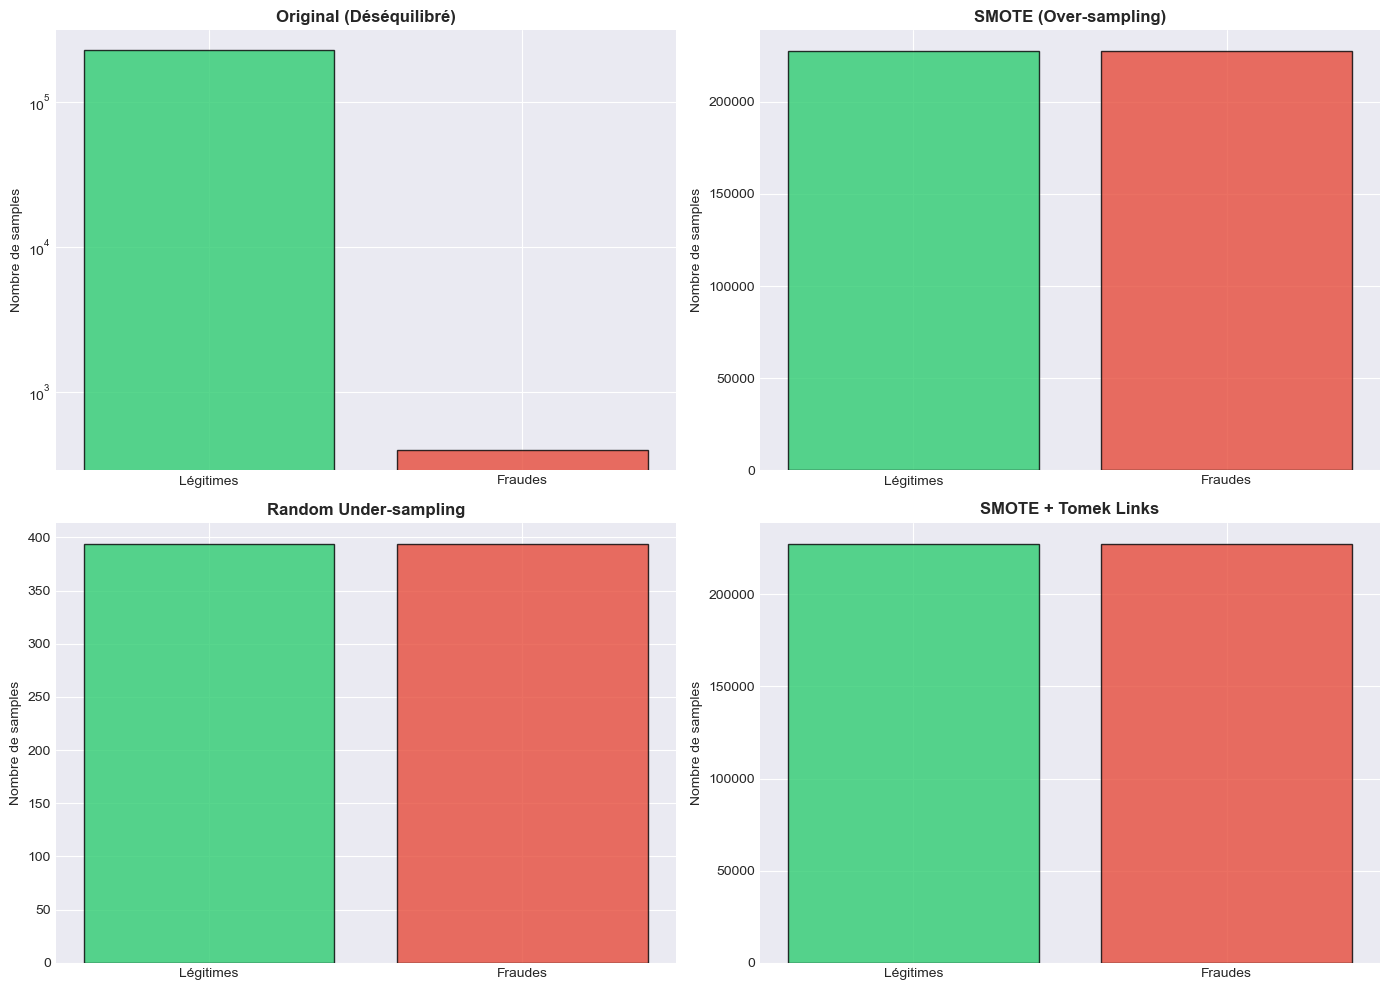


 Graphique sauvegardé: reports/figures/08_resampling_comparison.png




In [19]:
# ============================================================================
# 7.5 Visualisation comparative
# ============================================================================

print("\n" + "-"*80)
print(" Visualisation comparative")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original
axes[0, 0].bar(['Légitimes', 'Fraudes'], 
               [(y_train == 0).sum(), (y_train == 1).sum()],
               color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
axes[0, 0].set_title('Original (Déséquilibré)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Nombre de samples')
axes[0, 0].set_yscale('log')

# SMOTE
axes[0, 1].bar(['Légitimes', 'Fraudes'], 
               [(y_train_smote == 0).sum(), (y_train_smote == 1).sum()],
               color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
axes[0, 1].set_title('SMOTE (Over-sampling)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Nombre de samples')

# Random Under-sampling
axes[1, 0].bar(['Légitimes', 'Fraudes'], 
               [(y_train_rus == 0).sum(), (y_train_rus == 1).sum()],
               color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
axes[1, 0].set_title('Random Under-sampling', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Nombre de samples')

# SMOTE + Tomek
axes[1, 1].bar(['Légitimes', 'Fraudes'], 
               [(y_train_smotetomek == 0).sum(), (y_train_smotetomek == 1).sum()],
               color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
axes[1, 1].set_title('SMOTE + Tomek Links', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Nombre de samples')

plt.tight_layout()
plt.savefig('reports/figures/08_resampling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Graphique sauvegardé: reports/figures/08_resampling_comparison.png")
print("\n" + "="*80 + "\n")

In [20]:
# ============================================================================
# 8. SAUVEGARDE DES DONNÉES PRÉTRAITÉES
# ============================================================================

print(" SAUVEGARDE DES DONNÉES PRÉTRAITÉES")
print("="*80)

# Créer le dossier si nécessaire
import os
os.makedirs('data/processed', exist_ok=True)

# Sauvegarder les différentes versions
datasets = {
    'original': (X_train_scaled, y_train, X_test_scaled, y_test),
    'smote': (X_train_smote, y_train_smote, X_test_scaled, y_test),
    'undersampling': (X_train_rus, y_train_rus, X_test_scaled, y_test),
    'smote_tomek': (X_train_smotetomek, y_train_smotetomek, X_test_scaled, y_test)
}

for name, (X_tr, y_tr, X_te, y_te) in datasets.items():
    # Sauvegarder
    joblib.dump(X_tr, f'data/processed/X_train_{name}.pkl')
    joblib.dump(y_tr, f'data/processed/y_train_{name}.pkl')
    
    print(f" {name.upper():<20} sauvegardé")

# Sauvegarder test une seule fois (commun à toutes les techniques)
joblib.dump(X_test_scaled, 'data/processed/X_test.pkl')
joblib.dump(y_test, 'data/processed/y_test.pkl')

print(f"\n Tous les fichiers sauvegardés dans: data/processed/")

print("\n" + "="*80 + "\n")

 SAUVEGARDE DES DONNÉES PRÉTRAITÉES
 ORIGINAL             sauvegardé
 SMOTE                sauvegardé
 UNDERSAMPLING        sauvegardé
 SMOTE_TOMEK          sauvegardé

 Tous les fichiers sauvegardés dans: data/processed/




In [21]:
# ============================================================================
# 9. RÉSUMÉ ET RECOMMANDATIONS
# ============================================================================

print(" RÉSUMÉ DU PREPROCESSING")
print("="*80)

summary = f"""
 ÉTAPES RÉALISÉES:

1.  Chargement des données
   • {df.shape[0]:,} transactions chargées

2.  Split Train/Test stratifié
   • Train: {X_train.shape[0]:,} samples (80%)
   • Test: {X_test.shape[0]:,} samples (20%)
   • Stratification maintenue

3.  Feature Engineering
   • 4 nouvelles features temporelles créées
   • Hour, Day, Period, Is_Weekend

4.  Normalisation
   • RobustScaler appliqué (résistant aux outliers)
   • Features normalisées: Time, Amount, + nouvelles features
   • V1-V28 conservées (déjà normalisées par PCA)

5.  Gestion du déséquilibre (4 techniques)
   • SMOTE: {len(y_train_smote):,} samples équilibrés
   • Under-sampling: {len(y_train_rus):,} samples équilibrés
   • SMOTE+Tomek: {len(y_train_smotetomek):,} samples équilibrés
   • Original: pour modèles avec class_weight

6. Sauvegarde
   • 4 versions du dataset train
   • 1 version test commune
   • Scaler sauvegardé pour production

 FICHIERS GÉNÉRÉS:

data/processed/
├── X_train_original.pkl       (données originales + normalisées)
├── X_train_smote.pkl          (avec SMOTE)
├── X_train_undersampling.pkl  (avec under-sampling)
├── X_train_smote_tomek.pkl    (avec SMOTE+Tomek)
├── y_train_*.pkl              (labels correspondants)
├── X_test.pkl                 (test set)
└── y_test.pkl                 (test labels)

models/
└── scaler.pkl                 (RobustScaler fitted)

 RECOMMANDATIONS POUR LA MODÉLISATION:

✓ Tester TOUTES les techniques de rééchantillonnage
  → Chaque technique peut donner de meilleurs résultats selon le modèle

✓ Pour XGBoost et Random Forest:
  → Essayer avec class_weight/scale_pos_weight sur données originales
  → Comparer avec versions rééchantillonnées

✓ Pour Isolation Forest:
  → Utiliser les données originales (détection d'anomalies)

✓ Validation croisée:
  → Utiliser StratifiedKFold (5 ou 10 folds)
  → Maintenir le ratio fraude/légitime

✓ Métriques prioritaires:
  → Recall (capturer toutes les fraudes)
  → Precision-Recall AUC
  → F1-Score
  → Matrice de confusion

 PROCHAINE ÉTAPE: 03_modeling.ipynb
   → Entraînement des modèles
   → Comparaison des performances
   → Hyperparameter tuning
"""

print(summary)
print("="*80)
print("\n PREPROCESSING TERMINÉ!")
print("🎯 Vous êtes prêt pour la modélisation!")
print("\n" + "="*80)

 RÉSUMÉ DU PREPROCESSING

 ÉTAPES RÉALISÉES:

1.  Chargement des données
   • 284,807 transactions chargées

2.  Split Train/Test stratifié
   • Train: 227,845 samples (80%)
   • Test: 56,962 samples (20%)
   • Stratification maintenue

3.  Feature Engineering
   • 4 nouvelles features temporelles créées
   • Hour, Day, Period, Is_Weekend

4.  Normalisation
   • RobustScaler appliqué (résistant aux outliers)
   • Features normalisées: Time, Amount, + nouvelles features
   • V1-V28 conservées (déjà normalisées par PCA)

5.  Gestion du déséquilibre (4 techniques)
   • SMOTE: 454,902 samples équilibrés
   • Under-sampling: 788 samples équilibrés
   • SMOTE+Tomek: 454,902 samples équilibrés
   • Original: pour modèles avec class_weight

6. Sauvegarde
   • 4 versions du dataset train
   • 1 version test commune
   • Scaler sauvegardé pour production

 FICHIERS GÉNÉRÉS:

data/processed/
├── X_train_original.pkl       (données originales + normalisées)
├── X_train_smote.pkl          (avec SMO